# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 2: EDA

## Introduction

In this notebook, we will conduct exploratory data analysis (EDA) to gain a deeper understanding of our datasets. Through data visualizations, we aim to uncover insights into the distributions of key data features and review texts.

Our EDA will proceed in the following stages as we seek to understand:

- The distribution of the number of listings and the number of reviews.
- The correlation between listing-related features and rating scores.
- The distribution of overall ratings and subratings across all listings.
- How ratings are distributed among different price ranges.

Following these primary stages, we establish a sentiment threshold of **4.8** to classify outstanding and less-outstanding Airbnb listings.

We then explore:

- How different listing-related variables vary between outstanding and less outstanding listings.
- Common words found in all reviews.
- Differences in common words among reviews for outstanding and less outstanding listings.

Ultimately, we defined our future modeling question: **By predicting if a review corresponds to a listing with a rating score higher or lower than 4.8, we aim to identify key word features that hosts can utilize to improve their star ratings and position their listings among the outstanding candidates for potential guests to choose.**

***

# Table of Contents

1. [**Helper Function for Colormap**](#b1)<br>
2. [**Exploratory Data Analysis**](#b2)<br>
    1.1 [**Number of Listings by Host**](#b2.1)<br>
    1.2 [**Number of Listings by Number of Reviews**](#b2.2)<br>
    1.3 [**Different Review Ratings Correlations**](#b2.3)<br>
    1.4 [**Overall Rating with Numerical Features Correlation**](#b2.4)<br>
    1.5 [**Overall Rating Distribution by Rating Ranges**](#b2.5)<br>
    1.6 [**Sentiment distributions by Rating Types**](#b2.6)<br>
    1.7 [**Different Review Ratings Distribution**](#b2.7)<br>
    1.8 [**Average Review Ratings by Rating Type**](#b2.8)<br>
    1.9 [**Overall Ratings Distribution by Price Ranges**](#b2.9)<br>
    1.10 [**Histograms for all Numerical Features**](#b2.10)<br>
3. [**Review Findings**](#b3)<br>
    3.1 [**Word Cloud for All Reviews**](#b3.1)<br>
    3.2 [**Word Cloud for Reviews of Listings with Ratings 'above 4.8'**](#b3.2)<br>
    3.3 [**Word Cloud for Reviews of Listings with Ratings 'below 4.8'**](#b3.3)<br>
4. [**EDA Summary**](#b4)<br>

***

###  Import Libraries and Load cleaned data

In [1]:
# Importing libraries
import numpy as np
import pandas as pd

# Data Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.colors as cl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud

# Library to save data
import joblib

In [2]:
# Load the cleaned listing and review datas
df_listings_clean=joblib.load('data/df_listings_clean.pkl')
df_reviews_clean=joblib.load('data/df_reviews_clean.pkl')

***

# Helper Function <a id="b1"></a>

We will define a customised color map function to match with Airbnb's brand color: **Rausch**. This is so that all of our visuals are consistent throughout our analysis.

In [3]:
# Create a function to design customised color map
def custom_colormap(color, n=10):
    """
    Create a custom colormap with varying tints of the same color based on percentage.
    
    Parameters:
    color: str, the base color in hexadecimal format.
    n    : int, number of colors in the colormap.
    
    Returns:
    cmap : LinearSegmentedColormap, customised colormap object.
    """
    base_color = np.array(cl.to_rgb(color))
    colors = [base_color * (1 - i/n) + np.array([1, 1, 1]) * (i/n) for i in range(n)]
    colors = colors[::-1]
    
    return LinearSegmentedColormap.from_list('custom_colormap', colors, N=n)

# Exploratory Data Analysis <a id="b2"></a>

We can start the exploratory data analysis to gather some basic information about the two datasets, and also explore the statistical characteristics of the star ratings before we jump into the reviews. 

First, we can start by looking at the number of listings per host.

## Number of Listings by Host <a id="b2.1"></a>

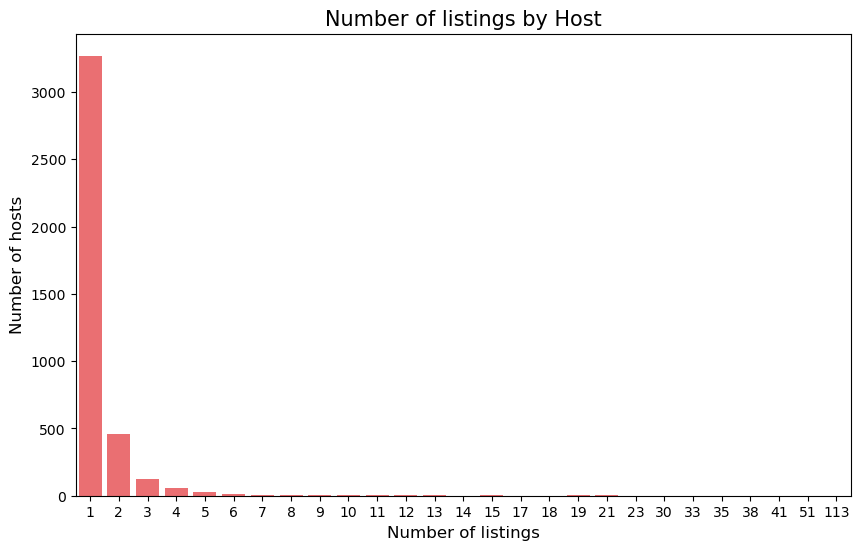

In [4]:
# Grouping by host_id and counting the number of listings for each host
listings_per_host = df_listings_clean.groupby('host_id').size()

# Counting the frequency of each count of listings
listings_count = listings_per_host.value_counts().sort_index()

# Plot figure
plt.figure(figsize=(10,6))
ax = sns.barplot(x=listings_count.index, y=listings_count.values, data=df_listings_clean, color='#FF5A5F')

# Edit labels
ax.set_title("Number of listings by Host", fontsize=15)
ax.set_xlabel("Number of listings", fontsize = 12)
ax.set_ylabel("Number of hosts", fontsize = 12)
ax.tick_params(axis='x')

plt.show()

- The histogram of the **number of listings by host** reveals a highly right-skewed distribution, indicating that most hosts possess only one rental property on Airbnb.

- However, a notable subset of hosts possess an elevated number of listings, potentially representing a group of commercial or non-private hosts. To investigate this further, a binary feature column can be created to differentiate between private and commercial hosts, facilitating an analysis of which group has higher ratings. The investigation can potentially provides some guidance for hosts considering expanding their rental portfolio on Airbnb.

***

## Number of Listings by Number of Reviews <a id="b2.2"></a>

In [5]:
# Grouping by host_id and counting the number of listings for each host
reviews_per_listing = df_reviews_clean.groupby('listing_id').size()

# Counting the frequency of each count of listings
reviews_count = reviews_per_listing.value_counts().sort_index()

# Show the number of listings by number of reviews count
reviews_count

3       184
4       169
5       144
6       126
7       136
       ... 
993       1
1000      1
1041      1
1046      1
1173      1
Length: 512, dtype: int64

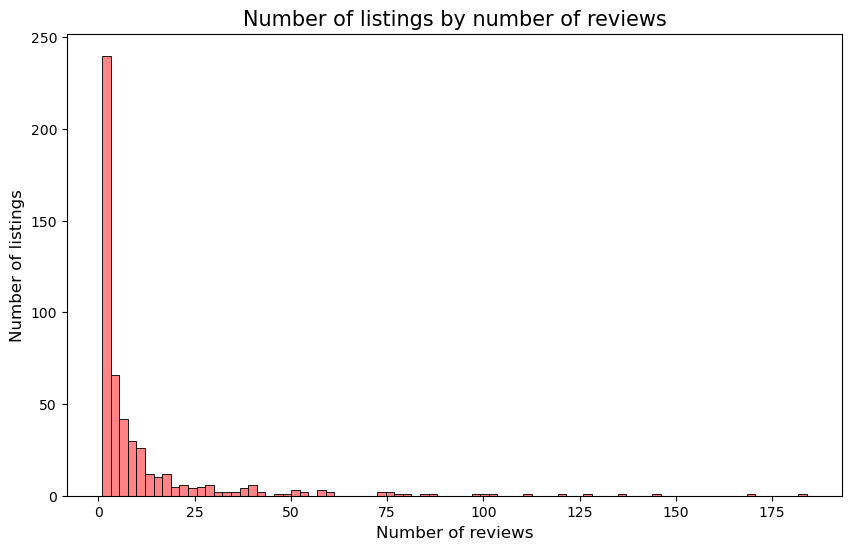

In [6]:
# plot figure
plt.figure(figsize=(10,6))

# Histogram shows the number of reviews distributed by the number of listings


# Plot figure
ax = sns.histplot(data=reviews_count.values,color='#FF5A5F')

# Add labels
ax.set_title("Number of listings by number of reviews", fontsize=15)
ax.set_xlabel("Number of reviews", fontsize = 12)
ax.set_ylabel("Number of listings", fontsize = 12)

plt.show()

- The histogram of **number of reviews** shows similar trend of the previous graph, with a highly right-skewed distribution. This skewness indicates that the majority of listings receive only a handful of reviews. Notably, a gap near **zero** on the x-axis is due to the filtering condition applied in the data cleaning process where only listings with more than **three** reviews were included for analysis. 

- However, the graph illustrates that some listings accumulate approximatley 175 reviews. It's worth mentioning that while the histogram captures the reviews up to this count, our initial calculation reveals that certain listings has up to **1000** reviews. This observation holds significance as the number of reviews can potentially affect the accuracy of predictions when using them to predict average ratings. Thus, we can use the review count as a predictive factor in ensuring the robustness of our predictions.

***

## Different Review Ratings Correlations <a id="b2.3"></a>

Next, we would like to see the correlation relationships between different types of ratings and thus obtain a general idea which subrating could potentially influence the overall rating the most.

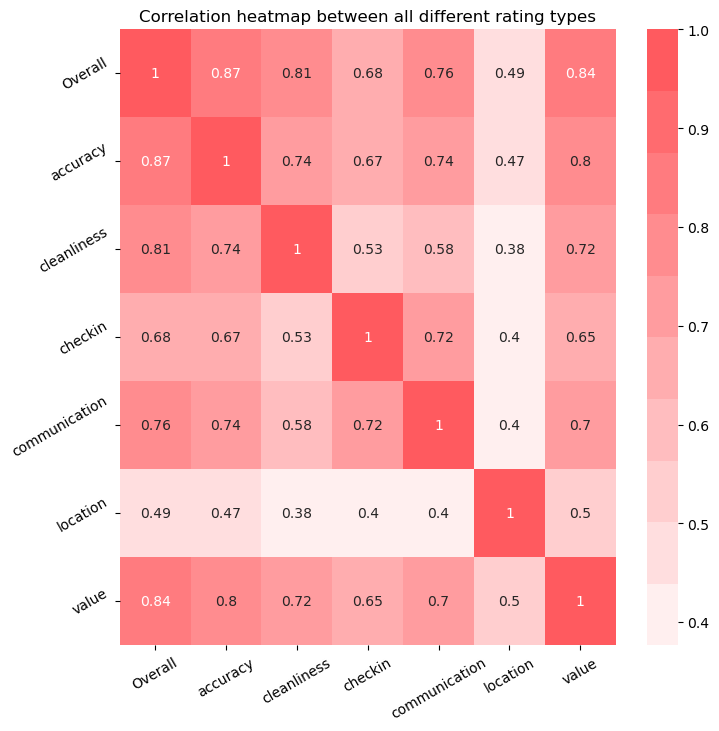

In [37]:
# Rename the review_scores_rating to overall rating in order to prevent confusions
df_listings_clean = df_listings_clean.rename(columns={'review_scores_rating': 'review_scores_Overall'})

# Create dataframe that only contains different average ratings scores
df_ratings=df_listings_clean[['review_scores_Overall',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]

# Rename rating scores for better visual
df_ratings_renamed = df_ratings.copy()
rating_names=df_ratings.columns
rating_names_edit = []
for i in rating_names:
    rating_names_edit.append(i.split('_')[2])

for i in range(len(rating_names)):
    df_ratings_renamed.rename(columns = {rating_names[i]:rating_names_edit[i]}, inplace=True)

# Determine the graph size
plt.figure(figsize=(8,8))

# Plot the correlation heatmap between all different rating types
sns.heatmap(df_ratings_renamed.corr(),cmap=custom_colormap('#FF5A5F'), annot=True )
plt.xticks(rotation=30)

plt.yticks(rotation=30)

# Add title
plt.title('Correlation heatmap between all different rating types', fontsize=12)

#plt.savefig('ratings_corr.jpg', dpi=300)
plt.show()

**Strong Correlations with Overall Rating**

The accuracy rating score, cleanliness rating score, and value rating score show strong correlations with the overall rating score. This suggests that these three aspects - accuracy of rental description, cleanliness, and perceived value - significantly impact guests' overall satisfaction and rating of the rental.

**Weak Correlation with Overall Rating**

In contrast, the location rating score demonstrates the weakest correlation with the overall rating score. Additionally, it shows weak relationships with all other subrating scores. This implies that the location of the rental has less influence on guests' overall satisfaction compared to other factors.

**Adjustability and impact on ratings**

Hosts have the opportunity to adjust factors such as rental description accuracy, overall cleanliness, and the perceived value of the rental. Given their strong correlations with the overall rating, improving these aspects could lead to higher overall ratings and increased guest satisfaction. Conversely, the location of the rental, being less adjustable, tends to have a weaker impact on overall ratings.

**Focus on predicting subratings**

Based on this correlation map, it's evident that predicting the accuracy, cleanliness, and value ratings could be equally important as predicting the **overall rating**. Focusing on predicting these subratings accurately can provide hosts with deeper insights into specific areas for improvements.

***

## Overall Rating with Numerical Features Correlation <a id="b2.4"></a>

Next, we will look at the relationship between all the numerical features in our listing dataset and the overall rating.

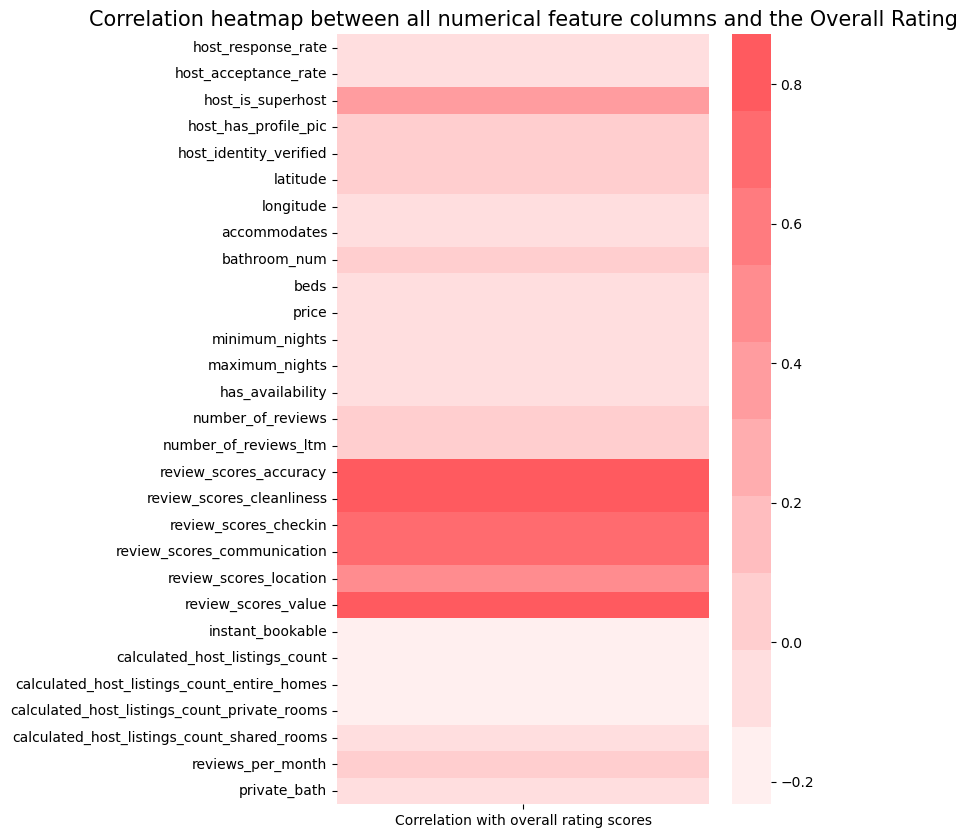

In [8]:
# Return list of numerical column names
num_cols=df_listings_clean.select_dtypes(exclude='object').columns

# Remove irrelevant columns from the list
num_cols_clean=num_cols.drop(['id', 'host_id', 'review_scores_Overall'])

# Return correlation coefficients between overall rating and the rest of the numerical features
corr_with_ratings=df_listings_clean[num_cols_clean].corrwith(df_listings_clean['review_scores_Overall'])


# Adjust figure size
plt.figure(figsize=(6,10))

# Plot the correlation heatmap
sns.heatmap(pd.DataFrame(corr_with_ratings, columns=['Correlation with overall rating scores']), cmap=custom_colormap('#FF5A5F'))

# Add title
plt.title('Correlation heatmap between all numerical feature columns and the Overall Rating', fontsize=15)

plt.show()

- The correlation heatmap between all numerical features in the dataset and the **Overall Rating** score reveals that, aside from the sub ratings, none of the current numerical features show a strong relationship with the Overall Rating score. This highlights the limited influence of the current features. Therefore, to effectively predict and analyze overall rating behavior, it is important to incorporate other sources of information such as customer reviews.

***

## Overall Rating Distribution by Rating Ranges <a id="b2.5"></a>

Now, we are interested in the distribution of overall rating scores. Upon examining the statistical distribution, we observe that the ratings predominantly exceed 4. 

Consequently, we aim to visualize the distribution more clearly by segregating the data into different ranges above 4. This segmentation will allow us to gain a clearer understanding of the distribution of ratings and identify any potential patterns or anomalies within these higher ranges.

In [9]:
# Statistical distribution of the overall rating scores
df_ratings['review_scores_Overall'].describe()

count    5910.000000
mean        4.779514
std         0.241136
min         2.250000
25%         4.690000
50%         4.850000
75%         4.940000
max         5.000000
Name: review_scores_Overall, dtype: float64

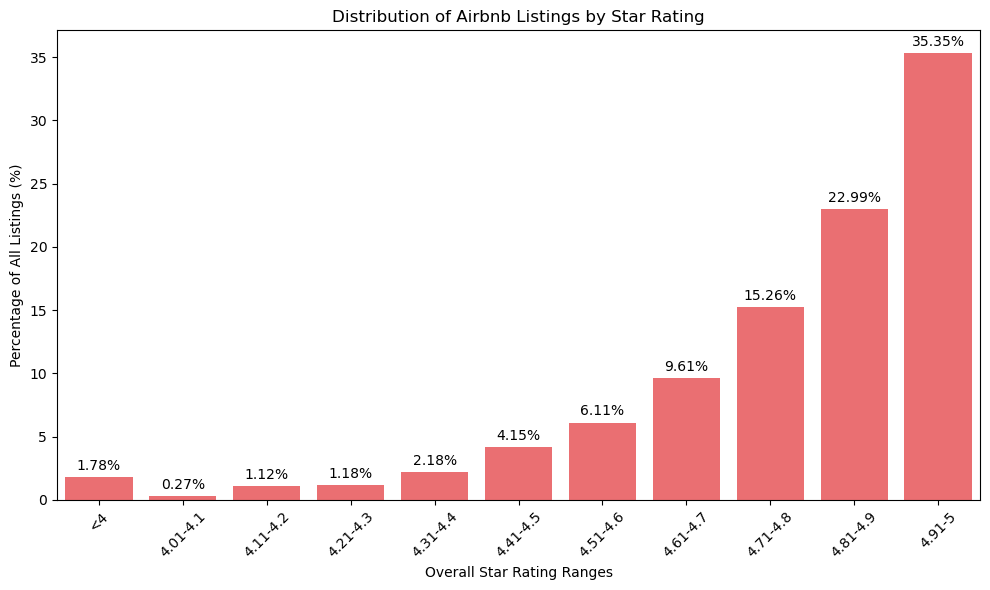

In [10]:
# Define bins and labels for the star rating ranges
bins = [0, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5]
labels = ['<4', '4.01-4.1', '4.11-4.2', '4.21-4.3', '4.31-4.4', '4.41-4.5',
          '4.51-4.6', '4.61-4.7', '4.71-4.8', '4.81-4.9', '4.91-5']

# Bin the data into the specified ranges
overall_ratings_by_range = pd.cut(df_ratings['review_scores_Overall'], bins=bins, labels=labels, include_lowest=True)

# Calculate the percentage of listings in each bin
percentage_df = overall_ratings_by_range.value_counts(normalize=True).sort_index() * 100

# Reset index to have the rating range as a column
percentage_df = percentage_df.reset_index()
percentage_df.columns = ['rating_range', 'percentage']

# Plot
plt.figure(figsize=(10,6))
barplot = sns.barplot(x='rating_range', y='percentage', data=percentage_df, color='#FF5A5F')

# Annotate each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}%', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', 
                     xytext=(0, 8), 
                     textcoords='offset points')

# Setting the titles and labels
plt.title('Distribution of Airbnb Listings by Star Rating')
plt.xlabel('Overall Star Rating Ranges')
plt.ylabel('Percentage of All Listings (%)')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

#plt.savefig('Distribution_of_listings_by_rating.jpg', dpi=600)

plt.show()

- The overall rating scores continue to display a left-skewed distribution even after segregating into ranges above 4. It's evident that more than **74%** of the listings achieve an overall rating above 4.7, indicating a prevalent trend towards high ratings. Conversely, less than **2%** of listings receive an overall rating below 4. 

- This distribution underscores the predominance of positive ratings across the dataset. Therefore, it is logical to transform this rating distribution into sentiments, categorizing listings with scores above **4.8** as 1, and those below **4.8** as 0. This transformation enables us to enhance classification predictions and simplify our model assumption. We will perform this transformation for all rating types.

### Transform Rating Scores to Sentiment Scores

In [11]:
# Define Sentiment Classification Threshold
threshold=4.8

# Create transformation function
def convert_to_sent(score):
    if score>threshold:
        return 1
    else:
        return 0

# Create sentiment dataframe
df_sentiment=pd.DataFrame()
    
# Apply transformation to each column in the rating dataframe
for i in df_ratings.columns:
    temp_i_list = df_ratings[i].apply(convert_to_sent)
    temp_name=i.split('_')[2]+'_sentiment'
    df_sentiment[temp_name] = temp_i_list

# Merge the sentiments to the original dataframe
df_listings_clean_senti = pd.concat([df_listings_clean, df_sentiment], axis=1)

***


## Sentiment distributions by Rating Types <a id="b2.6"></a>

After transforming the ratings into sentiments, we can now visualize the proportion of these sentiments using a bar plot. This visualization will provide insights into whether our target variables are imbalanced.

In [12]:
df_sentiment

,Overall_sentiment,accuracy_sentiment,cleanliness_sentiment,checkin_sentiment,communication_sentiment,location_sentiment,value_sentiment
0,1,1,1,1,1,1,1
1,0,1,0,1,1,1,0
2,0,0,0,1,0,0,0
3,0,0,0,1,1,0,0
4,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...
5905,1,1,1,1,1,1,1
5906,0,0,0,0,1,0,0
5907,0,0,0,0,0,0,0
5908,1,1,1,1,1,1,1


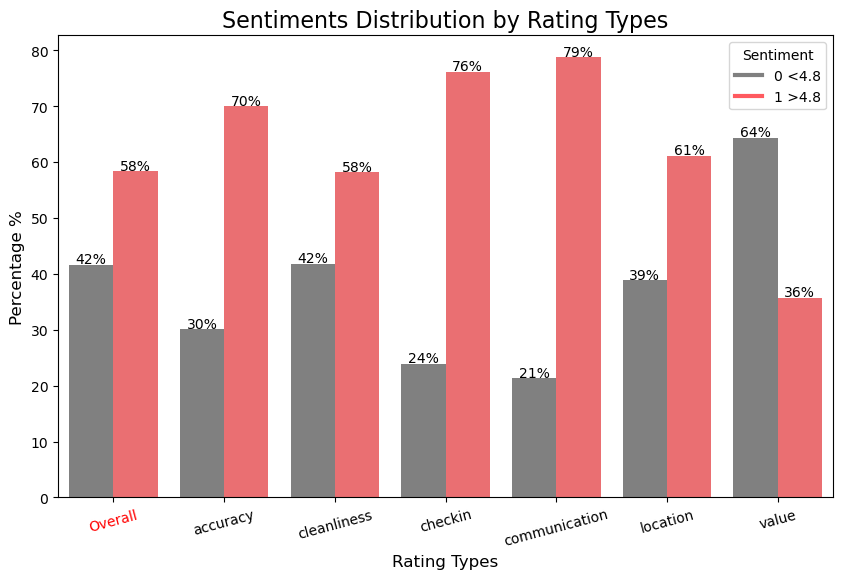

In [13]:
# Create lists contain sentiment types and proportion of positive and negative sentiments
rating_type=[]
sentiment=[]
proportion=[]

for i in df_sentiment.columns:
    new_name=i.replace('_sentiment', '')
    df_sentiment = df_sentiment.rename(columns={i: new_name})

for i in df_sentiment.columns:
    rating_type.extend([i,i])
    sentiment.extend([0,1])
    proportion.extend([
        (1-df_sentiment.mean()[i])*100,
        (df_sentiment.mean()[i])*100
    ])

# Create sentiment proportion dataframe
df_sentiment_proportions =pd.DataFrame({
    'Rating_Type': rating_type,
    'Sentiment': sentiment,
    'Proportion': proportion
})

# Determine figure size
plt.figure(figsize=(10, 6))

# Plot two bars per sentiment type 
ax=sns.barplot(data=df_sentiment_proportions, 
            x='Rating_Type', 
            y='Proportion', 
            hue='Sentiment', 
            palette=['grey', '#FF5A5F'])

# Add annotation
for p in ax.patches:
    height=p.get_height()
    ax.annotate(f'{height:.0f}%', 
                (p.get_x() + p.get_width() / 2., 
                 p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0,4), 
                textcoords = 'offset points')

# Add labels and legends
plt.title('Sentiments Distribution by Rating Types',fontsize=16)
plt.xlabel('Rating Types',fontsize=12)
plt.ylabel('Percentage %',fontsize=12)

plt.legend(title='Sentiment', 
           labels=['0 <4.8', '1 >4.8'],
           handles=[
    plt.Line2D([0], [0], color='grey', lw=3),
    plt.Line2D([0], [0], color='#FF5A5F', lw=3)
])

# Adjust layouts and labels
plt.xticks(rotation=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.axes.get_xticklabels()[0].set_color('red')

# plt.savefig('Sentiments_Distribution_by_Rating_Types.jpg', dpi =300)

plt.show()

- From the grouped bar plot above, we observe that the overall sentiment comprises **58%** positive sentiments, indicating an equal proportion of listings with a rating score higher than 4.8. This is fine for our model later as it is not imbalanced towards one of the sentiment.

- The proportions for the other sub-ratings are also intriguing. The communication sentiment proportions reveal that **79%** of people rate listings higher than 4.8, while the value sentiment is the only one showing a reversed proportion, where only **36%** of people would rate listings higher than 4.8. This suggests that it is more challenging for people to rate higher for the value of the Airbnb, while it is conversely easier to rate higher for host communication.

***

## Different Review Ratings Distribution <a id="b2.7"></a>

Next, we will discuss the distribution for different rating types in more details. 

In [14]:
# Create two lists contain index of listings differentiated by the rating scores of 4
rating_less_than_4 = []
for i in range(df_ratings.shape[0]):
    for j in df_ratings.columns:
        if df_ratings.loc[i][j] <4:
            rating_less_than_4.append(i)
rating_more_than_4 = ~df_ratings.index.isin(rating_less_than_4)

# Return two dataframes contain differentiated listings
df_ratings_less_than_4=df_ratings.loc[rating_less_than_4]
df_ratings_more_than_4=df_ratings.loc[rating_more_than_4]

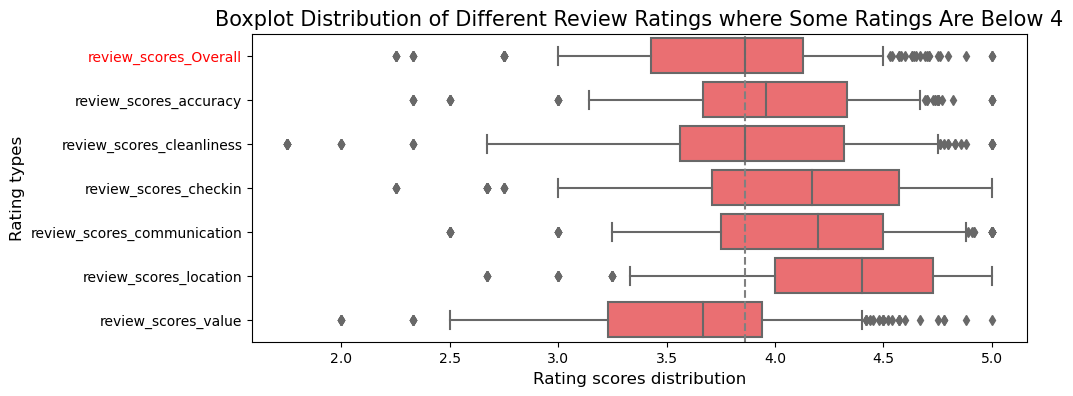

In [15]:
# Draw boxplots for all columns on the same plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
ax = sns.boxplot(data=df_ratings_less_than_4, orient='h', color='#FF5A5F', whis=[5, 95])

# Edit labels
ax.set_title("Boxplot Distribution of Different Review Ratings where Some Ratings Are Below 4", fontsize=15)
ax.set_xlabel("Rating scores distribution", fontsize = 12)
ax.set_ylabel("Rating types", fontsize = 12)

ax.axes.get_yticklabels()[0].set_color('red')

# Draw a line of Overall ratings mean on the boxplot 
line_position1 = df_ratings_less_than_4['review_scores_Overall'].median()  # Position of the line
plt.axvline(x=line_position1, color='grey', linestyle='--')

# Show figure
plt.show()

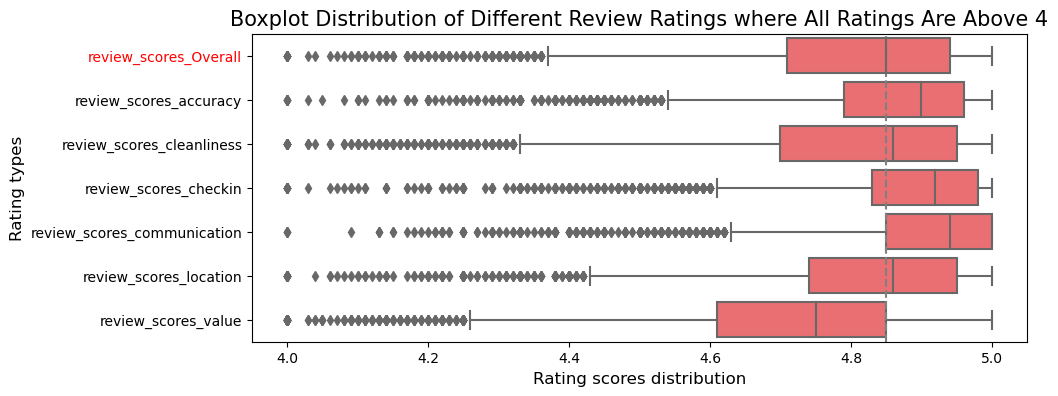

In [16]:
# Draw boxplots for all columns on the same plot using Seaborn
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
ax=sns.boxplot(data=df_ratings_more_than_4, orient='h', color= '#FF5A5F')

# Edit labels
ax.set_title("Boxplot Distribution of Different Review Ratings where All Ratings Are Above 4", fontsize=15)
ax.set_xlabel("Rating scores distribution", fontsize = 12)
ax.set_ylabel("Rating types", fontsize = 12)

ax.axes.get_yticklabels()[0].set_color('red')

# Draw a line on the boxplot
line_position = df_ratings_more_than_4['review_scores_Overall'].median()   # Position of the line
plt.axvline(x=line_position, color='grey', linestyle='--')

#ax.figure.savefig('output_figure.png',dpi=600)
plt.show()

Our analysis on the review ratings distribution is divided into two parts: analysis on listings with any rating lower than 4, and analysis on listings with all ratings higher than 4. This approach allows us to focus on visualizing ratings in more detail, particularly in the above 4 region, given that over 98% of the ratings fall within this range.

- In the first plot, we observe that besides the value scores, most of the other sub-ratings exhibit similar distributions to the overall ratings. However, the **cleanliness rating** shows a wider distribution, indicating that listings vary in their cleanliness levels, with some suffering from extremely low cleanliness scores. This discrepancy might be due to guests' strong aversion to dirty listings, leading them to rate them much lower. This trend is consistent in the plot for all ratings above 4, where the **value rating** exhibits the most variability, followed by cleanliness. Additionally, the overall rating has a **lower median** compared to most of the other ratings, while rating of **communication** tends to receive higher scores. These findings align with our previous observations.

***

## Average Review Ratings by Rating Type <a id="b2.8"></a>

Now that we have discussed the rating distributions as well as the transformed sentiment distributions. We can also visualize the average score for each of the rating type.

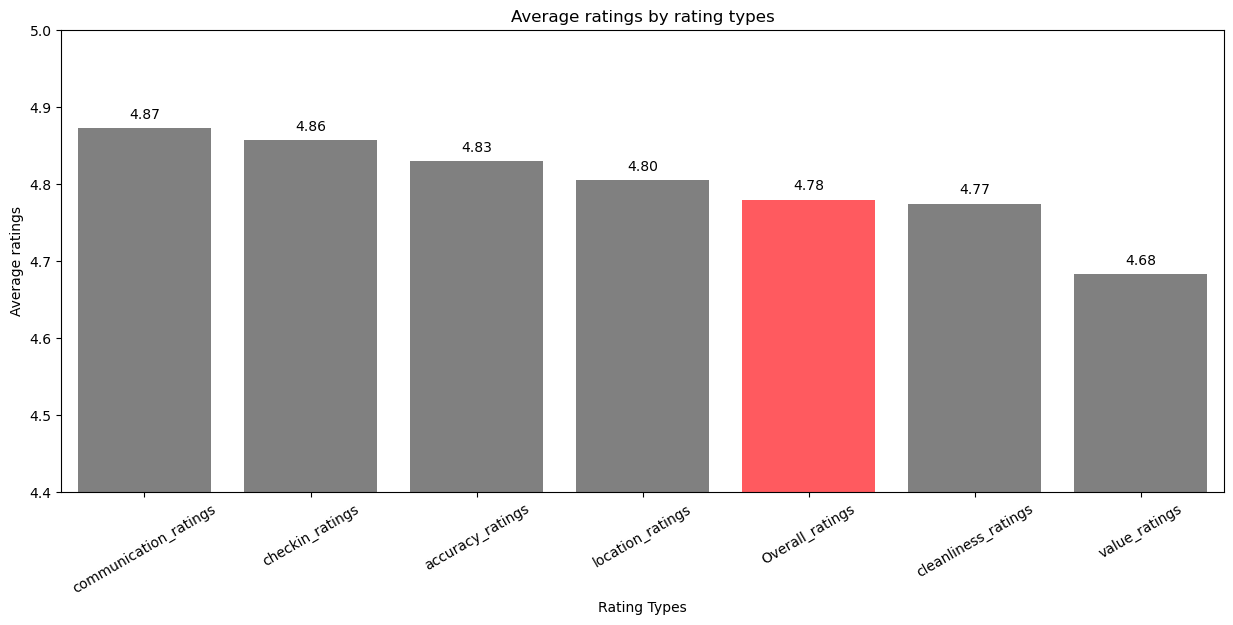

In [17]:
# Calculate the mean ratings for each review rating type including the overall rating
ratings_mean=df_ratings.mean().sort_values(ascending=False)

# Rename index values
ratings_mean=ratings_mean.rename(index={'review_scores_Overall': 'Overall_ratings', 
                                        'review_scores_accuracy': 'accuracy_ratings', 
                                        'review_scores_cleanliness':'cleanliness_ratings',
                                        'review_scores_checkin': 'checkin_ratings', 
                                        'review_scores_communication': 'communication_ratings',
                                        'review_scores_location':'location_ratings',
                                        'review_scores_value': 'value_ratings'})
# Set figure size
plt.figure(figsize=(15,6))

# Creating the barplot
ax = sns.barplot(x=ratings_mean.index, y=ratings_mean.values, errorbar=None, color='grey')


# Set different color for overall rating
ax.patches[4].set_facecolor('#FF5A5F') 

# Set labels
plt.title('Average ratings by rating types')
plt.xlabel('Rating Types')
plt.ylabel('Average ratings')

ax.set_xticklabels(ratings_mean.index, ha="right")

# Annotate the star ratings for each type of rating
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Edit x labels
plt.xticks(ha='center', rotation =30)

# Setting y-axis to start from 4.4
plt.ylim(4.4, 5)

plt.show()

The analysis reveals several key insights regarding guest ratings for listings. 

- Despite individual rating categories receiving high average scores above **4.6**, the overall average rating for listings tends to be slightly lower, indicating potential disparities in guest satisfaction across different aspects of the accommodation.

- Notably, guests appear to be particularly critical of the value aspect, with the value rating averaging **4.68**. This suggests that some guests may perceive certain listings as offering less value for the price paid, impacting their overall satisfaction.

- Therefore, we will explore whether cheaper listings tend to receive worse reviews to try to understand the relationship between pricing and guest satisfaction.

***

## Overall Ratings Distribution by Price Ranges <a id="b2.9"></a>

Because our findings on the sub-ratings distribution all indicate that guests tend to be crucial of the values of the listings, we are interested in how prices relate to the overall ratings.

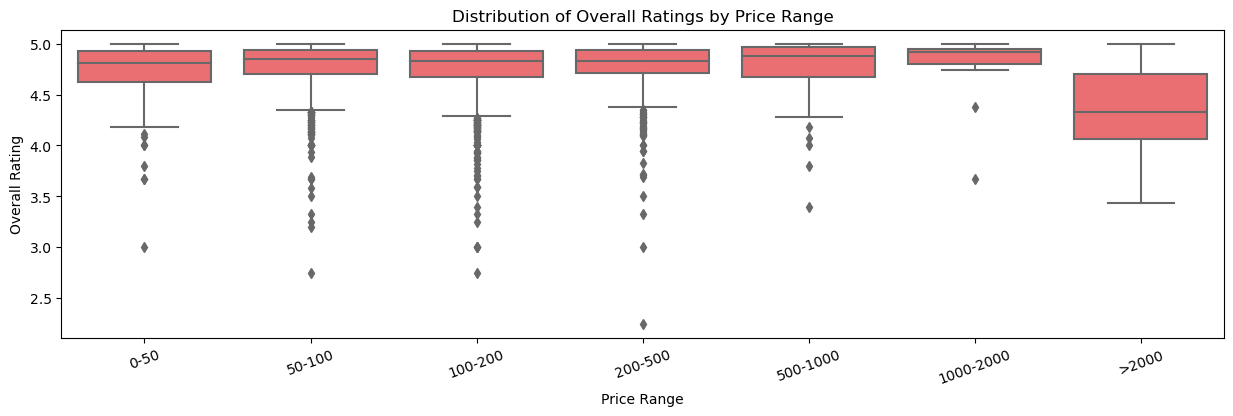

In [18]:
# Define price regions
price_ranges = [(0, 50),(50,100),(100, 200),(200, 500),(500,1000),(1000, 2000),(2000, np.inf)]

# Create dataframe contains price and overall rating information
df_ratings_by_price = df_listings_clean[['price', 'review_scores_Overall']]

# Extract series contain ranges for each row's price
price_by_range=pd.cut(df_ratings_by_price['price'], 
                      bins=[price_range[0] for price_range in price_ranges] + [np.inf], 
                      labels=[f"{price_range[0]}-{price_range[1]}" 
                              if price_range[1] != np.inf 
                              else f">{price_range[0]}" for price_range in price_ranges]
                     )

# Define figure size
plt.figure(figsize=(15, 4))

# Create boxplot
ax=sns.boxplot(x=price_by_range.values, y='review_scores_Overall', data=df_ratings_by_price, color='#FF5A5F')

# Add labels and title
ax.set_title('Distribution of Overall Ratings by Price Range')
ax.set_xlabel('Price Range')
ax.set_ylabel('Overall Rating')
plt.xticks(rotation=20)

plt.show()

- The boxplots reveal some intriguing results. We observe that listings with prices between **0-50** pounds do not exhibit low overall ratings; their distribution is similar to other price ranges. This suggests that guests may not have excessively high expectations for cheaper rentals, resulting in overall ratings that are not significantly lower. 

- Listings priced between **1000-2000** pounds tend to receive the highest ratings, indicating consistent positive feedback from guests towards listings within this price range. 

- However, listings priced at **more than 2000** pounds display a wider distribution of overall ratings, suggesting that guests have higher expectations for more expensive listings, leading to more various critical ratings. 

- The variability in the distribution of ratings for the middle price range indicates that it is unlikely to capture rating trends solely by checking the price of the listing. Therefore, it is crucial for us to use guest reviews to analyze overall ratings in more detail.

***

## Distribution of current binary columns

We would like to see the distributions of the current binary columns, so that we can decide whether these features are useful for our analysis or not by checking if they are imbalanced.

In [19]:
# Select current binary columns in the listing dataset
df_listings_binary=df_listings_clean[[i for i in df_listings_clean.columns if df_listings_clean[i].nunique()==2]]

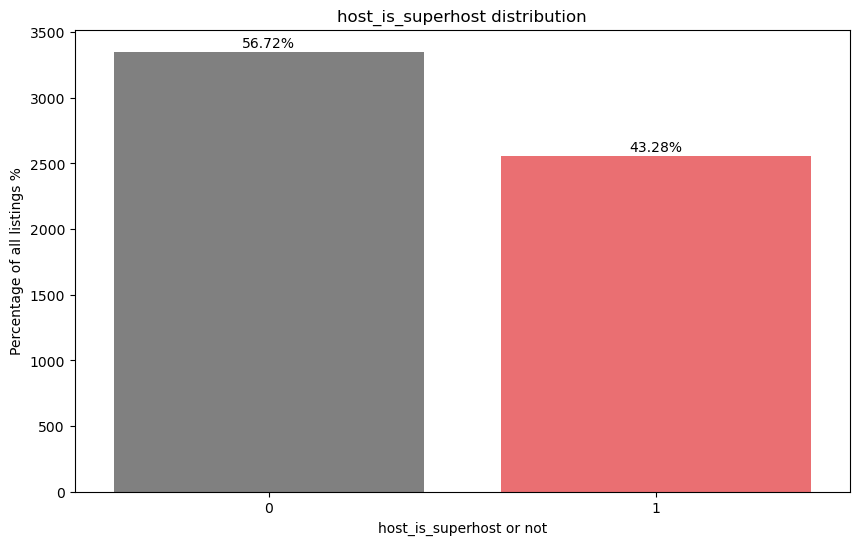

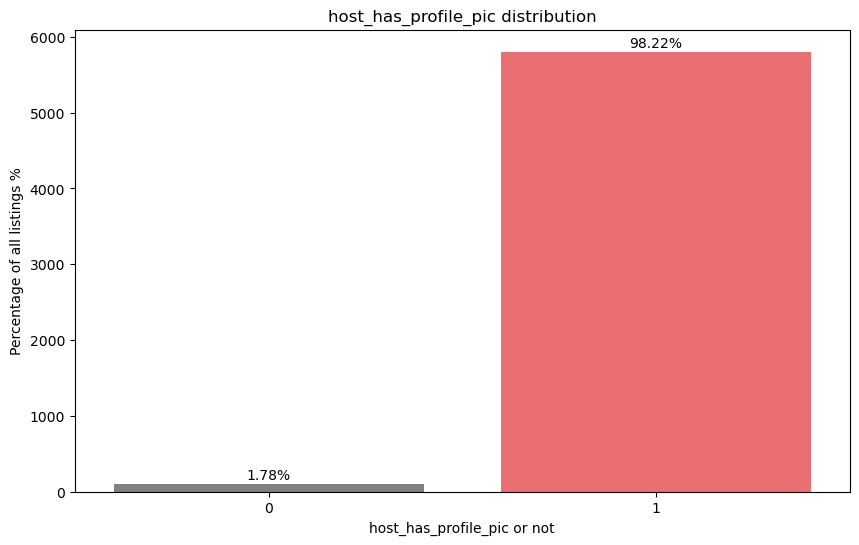

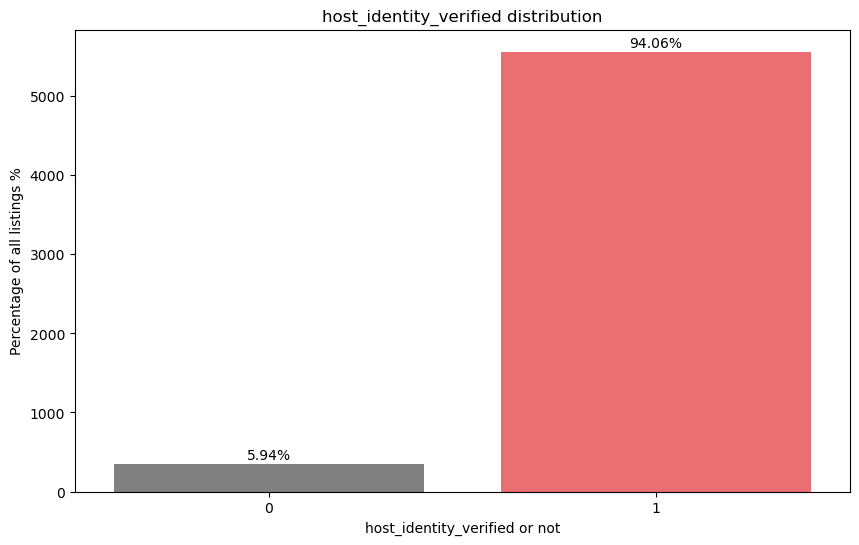

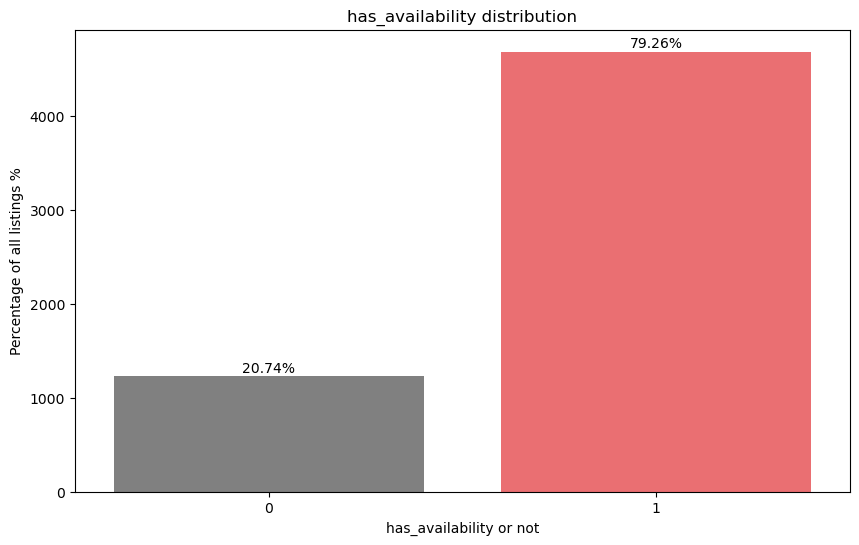

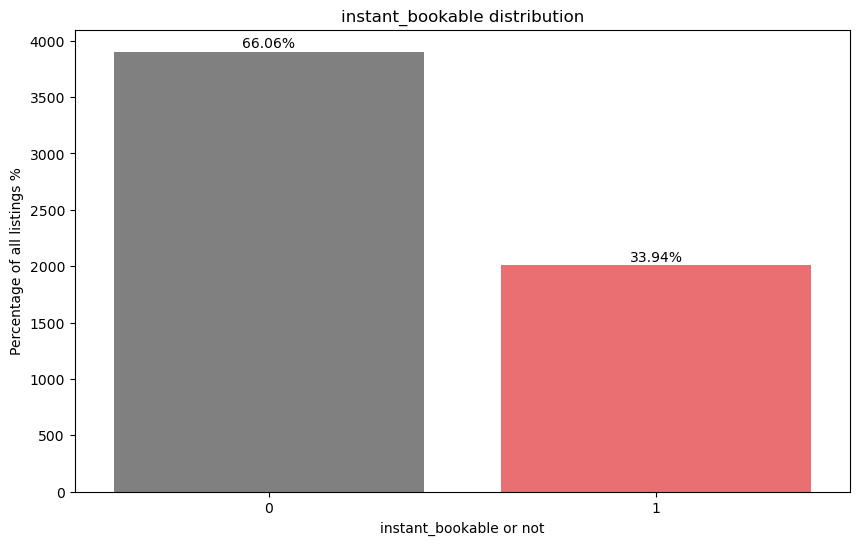

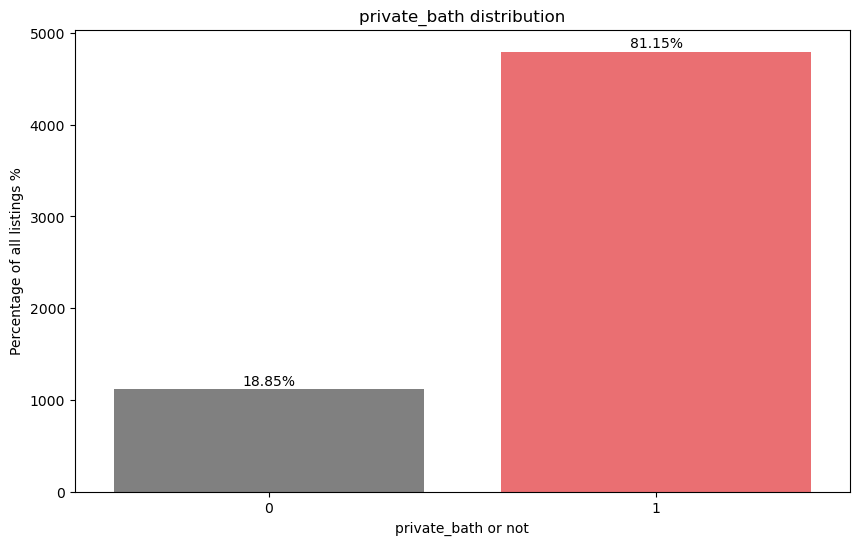

In [20]:
# Plot proportion barplot for all binary columns
for i in df_listings_binary.columns:
    # Decide each figure size
    plt.figure(figsize=(10,6))
    
    # Plot the barplot showing number of reviews with positive score and negative score respectively
    ax = sns.barplot(x=df_listings_binary[i].value_counts().index, 
                     y=df_listings_binary[i].value_counts().values,
                    palette=['grey', '#FF5A5F'])
    
    # Annotate with percentage
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/df_listings_binary.shape[0])
        height = p.get_height()
        ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points')

    # Add labels
    plt.title(f'{i} distribution')
    plt.xlabel(f'{i} or not')
    plt.ylabel('Percentage of all listings %')
    
    plt.show()        

From the above barplots, we observe that the `host_has_profile_pic` and `host_identity_verified` columns are highly imbalanced, which means they won't provide any useful information in our future analysis. Therefore, we will drop them in the later pre-processed stage.

***

## All Numerical Feature Histograms for Two Types of Listings (Sentiment=1 & Sentiment=0) <a id="b2.10"></a>

After classifying our listings into two categories: outstanding (Overall Sentiment=1) and less outstanding (Overall Sentiment=0), we can then examine whether any listing-related columns distribute differently among the two types. This can provide us with initial insights into which listing-related factors may contribute to an outstanding Airbnb listing. However, we will still include these features in the future modeling stage, as we expect our model to better capture the significance of how they indicate the classification statistically by looking at the model coefficients.

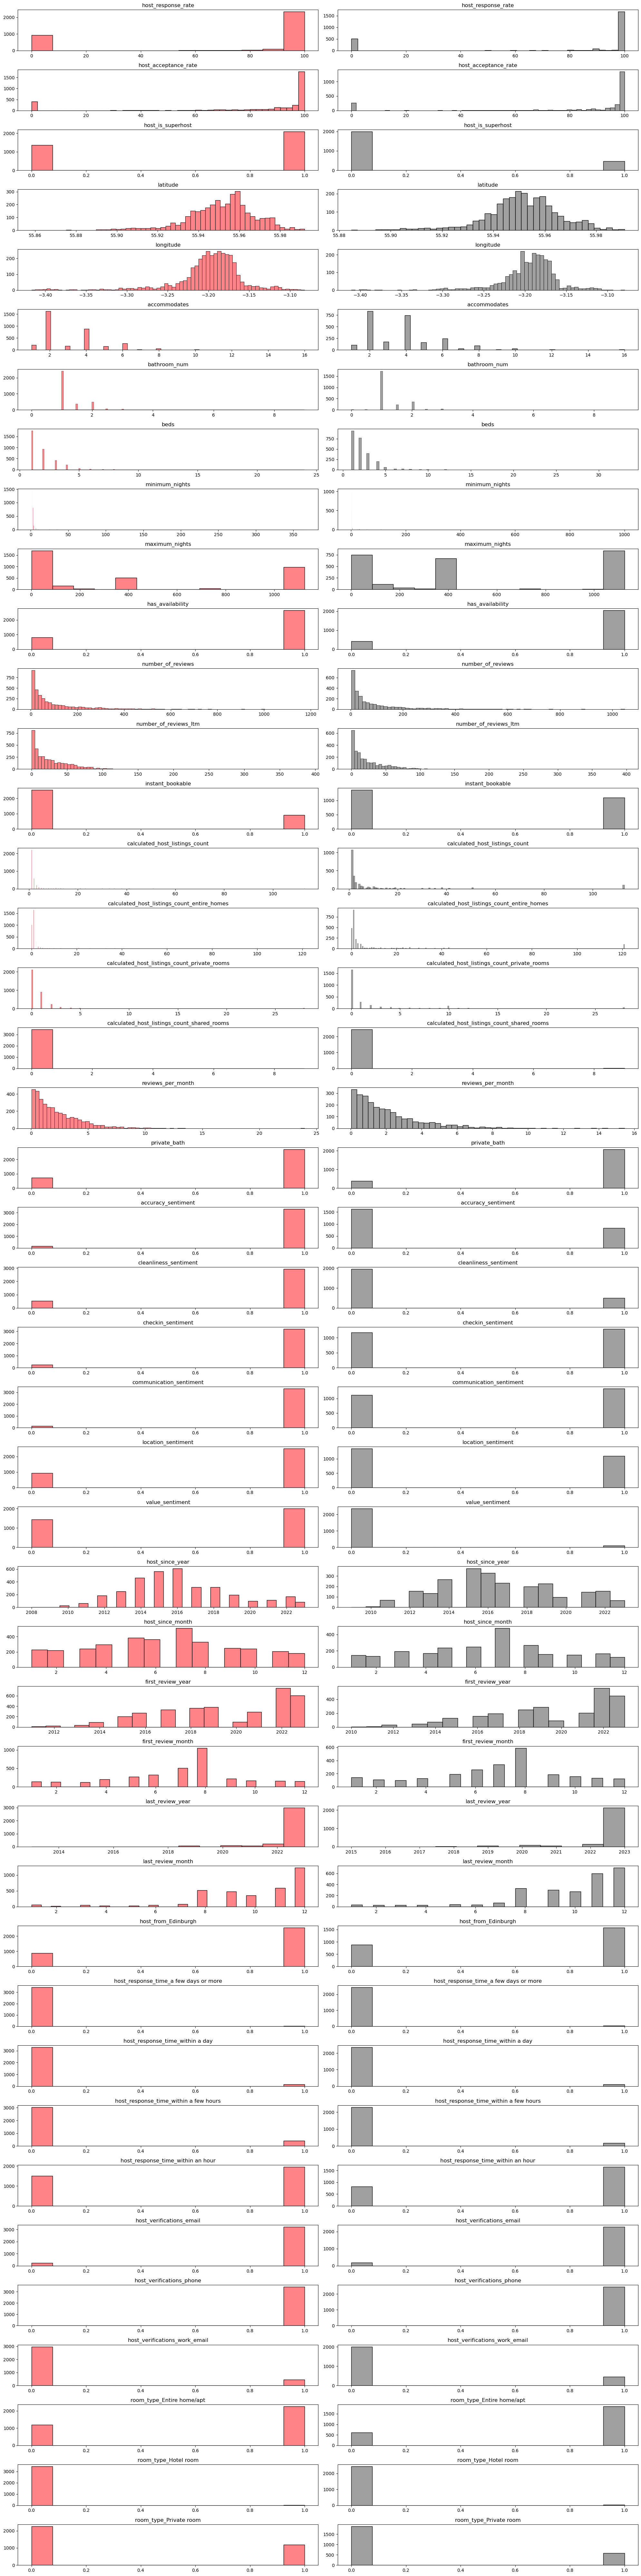

In [21]:
# Load pre-processed review data 
df_collapsed_reviews_by_listing = joblib.load('data/df_collapsed_reviews_by_listing.pkl')
df_reviews_by_listing = joblib.load('data/df_reviews_by_listing.pkl')

# Define two datasets based on overall sentiment threshold
df_pos = df_collapsed_reviews_by_listing[df_collapsed_reviews_by_listing['Overall_sentiment']==1].drop(['Overall_sentiment', 'comments'], axis=1)
df_neg = df_collapsed_reviews_by_listing[df_collapsed_reviews_by_listing['Overall_sentiment']==0].drop(['Overall_sentiment', 'comments'], axis=1)

# Define figure size
plt.figure(figsize=(20, 80))

# Plot pairwise plot for two types of listings for comparison
for i, col in enumerate(df_pos.columns):
    # Plot outstanding listings histograms
    plt.subplot(len(df_pos.columns), 2, 2*i+1)
    sns.histplot(df_pos[col], kde=False, color='#FF5A5F')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('') 
    # Plot less-outstanding listings histograms
    plt.subplot(len(df_neg.columns), 2, 2*i+2)
    sns.histplot(df_neg[col], kde=False, color='grey')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('') 

plt.tight_layout()
plt.show()

The above pairwise plots show how numerical features distribute for two types of listings: Outstanding (Overall sentiment = 1/rating >4.8) and Less-outstanding (Overall sentiment = 0/rating <= 4.8), where former plots are plotted with Airbnb Rausch color on the left, and latter plots are plotted with grey on the right.

By comparison, Although most of the plots show similar trends for both types of listings, we can still see that among outstanding listings, majority of them are hosted by **superhosts**, and conversely, majority of listings among less-outstanding listings are hosted by **non-superhosts**. This indicates that if a host is a superhost or not is a strong indicator for their star rating.

Additionally, we are able to observe different patterns among subratings as well. We observe that nearly all of outstanding listings still have communication sentiment more than 4.8, while nearly all of less-outstanding listings obtain value sentiment less than 4.8

The above pairwise plots illustrate how numerical features are distributed for two types of listings: Outstanding (Overall sentiment = 1/rating > 4.8) and Less-outstanding (Overall sentiment = 0/rating <= 4.8). The former plots are displayed with Airbnb Rausch color on the left, while the latter plots are shown in grey on the right.

Upon comparison, although most of the plots exhibit similar trends for both types of listings, we can still observe that among outstanding listings, the majority are hosted by **superhosts**, whereas the majority of listings among less-outstanding listings are hosted by **non-superhosts**. This suggests that whether a host is a superhost or not is a strong indicator of their star rating.

Additionally, we notice distinct patterns among subratings as well. Specifically, nearly all outstanding listings still maintain a **communication** sentiment score of more than 4.8, whereas nearly all less-outstanding listings have a **value** sentiment score of less than 4.8.

***

# Review Findings <a id="b3"></a>

## Word Cloud for All Reviews <a id="b3.1"></a>

There are 117552387 words in the combination of all reviews.


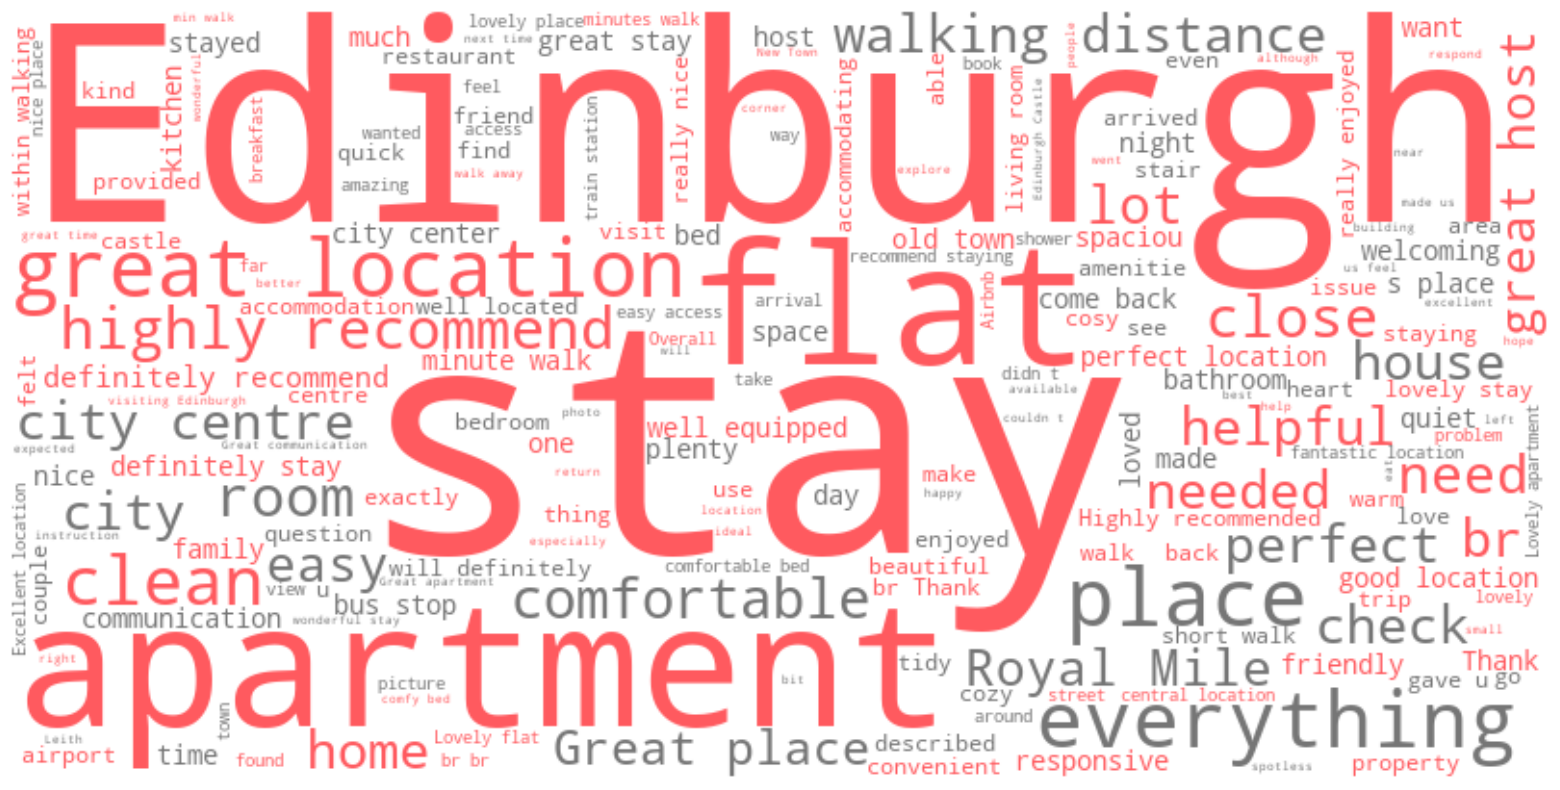

In [26]:
# Combine all reviews into a text to create wordcloud
text = ' '.join(review for review in df_reviews_by_listing['comments'])
print(f'There are {len(text)} words in the combination of all reviews.')

# Define the colors in hex format
colors_hex = ['#FF5A5F', '#767676']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Create the wordcloud
wordcloud = WordCloud(width=800, height=400,background_color= 'white', colormap = custom_cmap).generate(text)

# Define figure size
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.savefig('word_cloud.jpg', dpi =1000)
plt.show()

This word cloud displays the most frequent words in the cleaned review data. It's evident that since the data was chosen on Edinburgh Airbnbs, the word **'Edinburgh'** appears most frequently. Words like **'stay'** , **'flat'**, and **'apartment'** are also recognizable in the cloud. However, some of these words do not provide much information for our future analysis, so we will include them ('Edinburgh', 'flat', 'apartment') in our stop word list during the text vectorization stage of our modeling process.

Other recognizable words include **'comfortable'**, **'everything'**, and **'walking distance'** suggest that these might be key words that could potentially serve as indicators of guest sentiments.

## Word Cloud for Reviews Correspond to Listings with Overall Ratings above 4.8 <a id="b3.2"></a>

There are 76072337 words in the reviews correspond to listings with overall rating above 4.8.


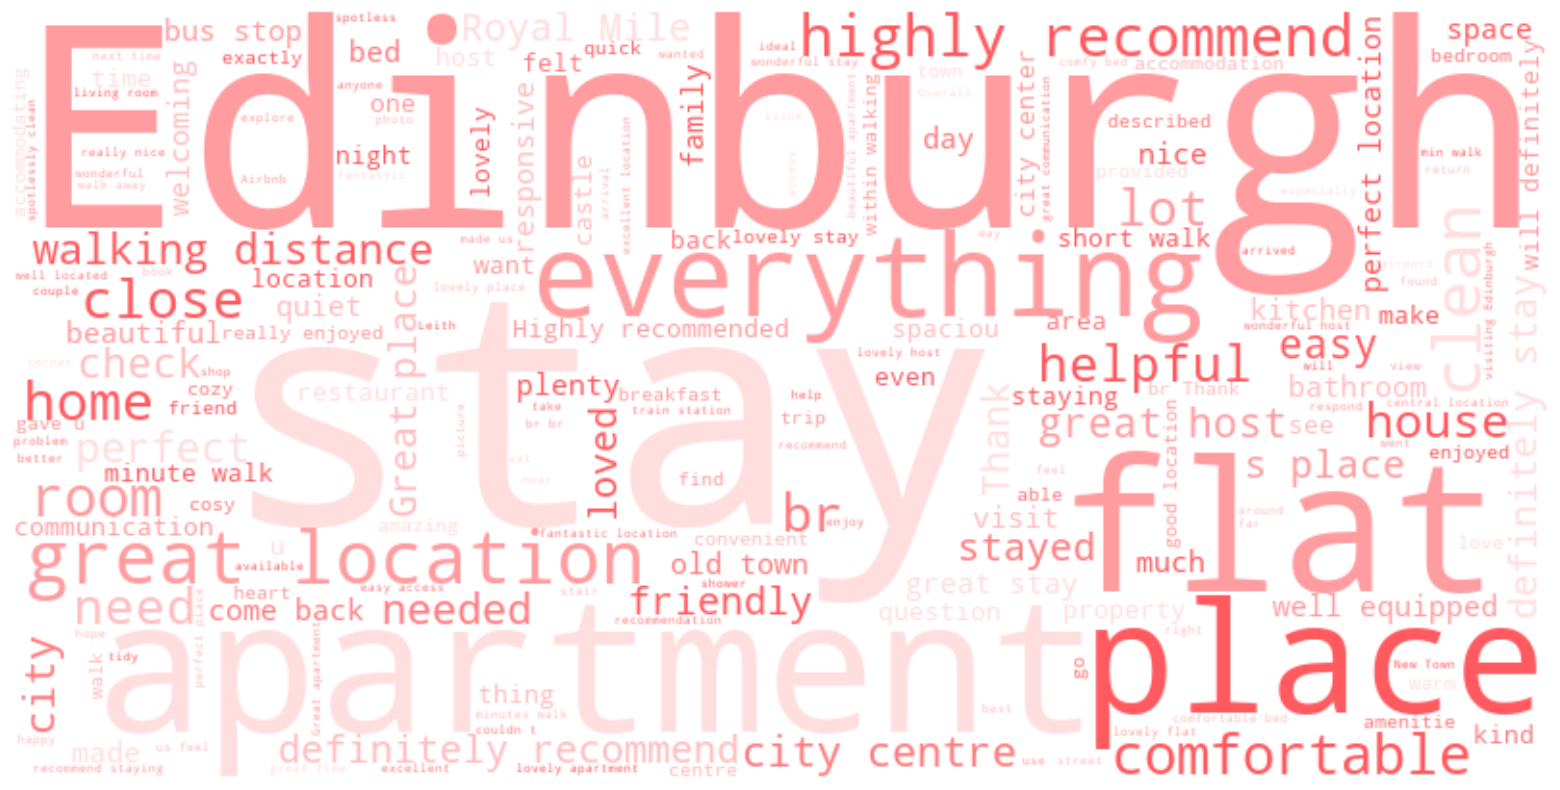

In [23]:
from wordcloud import WordCloud

# combine all reviews into a text to create wordcloud
text = ' '.join(review for review in df_reviews_by_listing[df_reviews_by_listing['Overall_sentiment'] == 1]['comments'])
print(f'There are {len(text)} words in the reviews correspond to listings with overall rating above 4.8.')

# create the wordcloud
wordcloud = WordCloud(width=800, height=400,background_color= 'white', colormap = custom_colormap('#FF5A5F', n=5)).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.savefig('word_cloud_pos.jpg', dpi =1000)
plt.show()

## Word Cloud for Reviews Correspond to Listings with Overall Ratings below 4.8 <a id="b3.3"></a>

There are 41480049 words in the reviews correspond to listings with overall rating below 4.8.


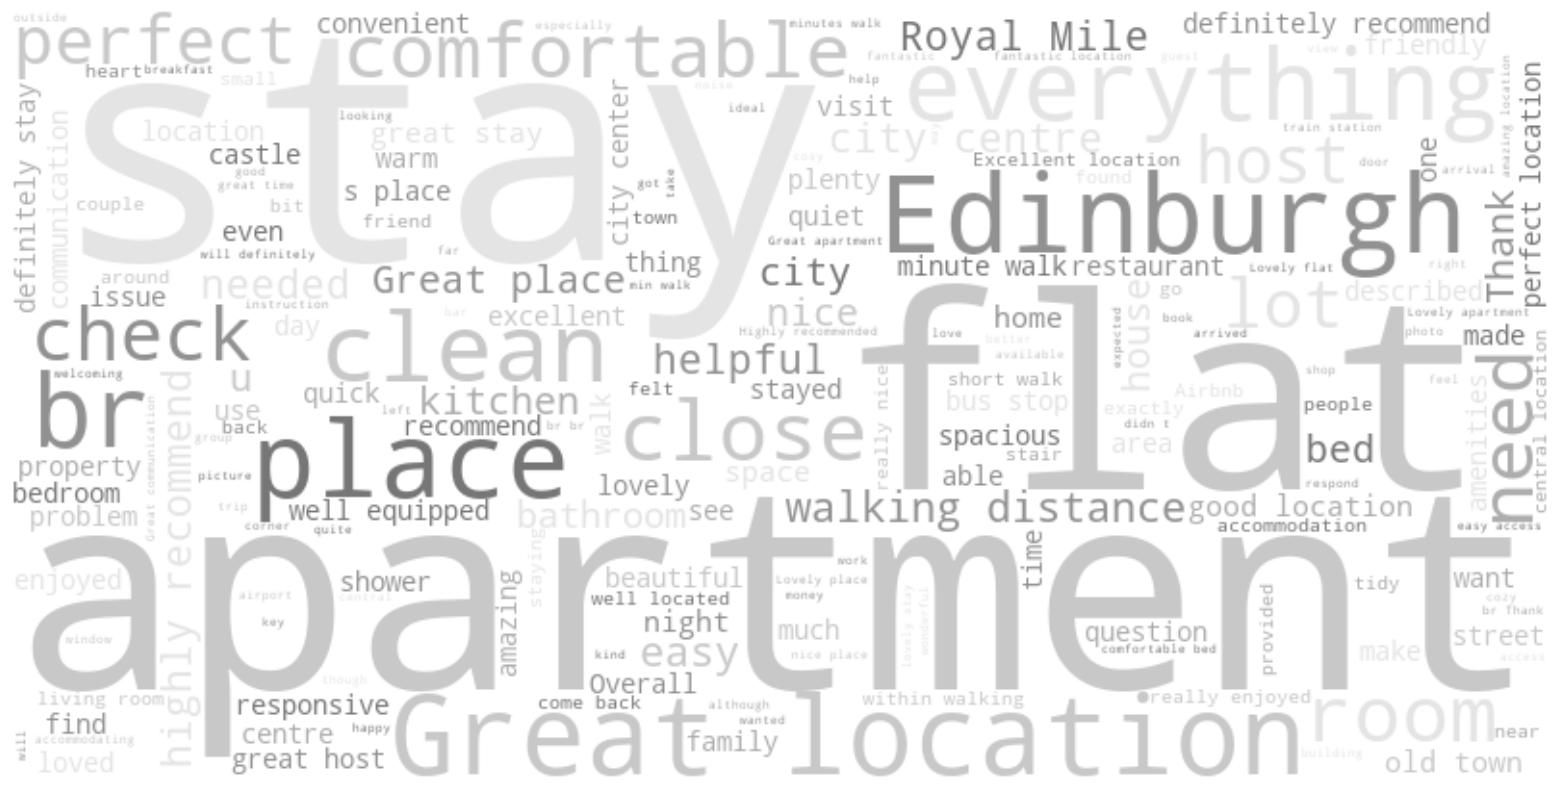

In [24]:
# Combine all reviews into a text to create wordcloud
text = ' '.join(review for review in df_reviews_by_listing[df_reviews_by_listing['Overall_sentiment'] == 0]['comments'])
print(f'There are {len(text)} words in the reviews correspond to listings with overall rating below 4.8.')

# Create the wordcloud
wordcloud = WordCloud(width=800, height=400,background_color= 'white', colormap = custom_colormap('#767676', n=5)).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.savefig('word_cloud_neg.jpg', dpi =1000)
plt.show()

After generating a wordcloud of all reviews in our dataset, we can also identify common words in reviews corresponding to listings with overall star ratings **above** or **below** 4.8. From these two word clouds, we observe that words such as **'Edinburgh'**, **'stay'** , **'flat'**, and **'apartment'** are also prevalent in both clouds. Additionally, positive words like **'Great'**, **'perfect'**, **'comfortable'** appear in the 'negative' word cloud as well as negative words like **'small'**, **'issue'**, etc. This highlights a significant challenge for our model: while we set our threshold at 4.8 to distinguish **'outstanding'** from **'less outstanding'** listings, there are a mix of negative and complimentary reviews associated with lower ratings, leading to an overall non-satisfactory result. 

This will potentially confuse our model because common positive words may not be the key indicators for determining our threshold. Conversely, we anticipate our model capturing more concentrated phrases to better identify outstanding and less satisfactory listings. This approach could potentially assist Airbnb hosts who are not currently experiencing low ratings but still desire insights into areas where they may fall short compared to excellent listings.

***

### Extract datasets

In [25]:
# Save data as pickle file in my data folder
# Dataset contains cleaned listing information as well as sentiment scores defined by 4.8
joblib.dump(df_listings_clean_senti, 'data/df_listings_clean_senti.pkl')

['data/df_listings_clean_senti.pkl']

***

# EDA Summary

In this notebook, we conducted advanced exploratory data analysis aimed at gaining insights and a better understanding of our dataset. The summarized insights are listed below:

- All subratings are positively correlated with the **overall rating**, with the location subrating showing the weakest correlation.
- More than 98% of listings have an overall rating above 4, making it challenging to interpret findings and define the modeling problem. Therefore, observing that about half of the listings have a rating above 4.8 (58%), we defined a threshold of 4.8 and transformed all star rating scores to binary sentiment scores (**0** for **less** than **4.8** & **1** for **more** than **4.8**).
- The **price** of the listings and their overall rating score have no obvious correlation, even when defining different price ranges and performing corresponding analyses. As we failed to fill in the rest of the null values in the price column, we decided to remove it from our future analysis, solely focus on the review texts and the rest of the listing features.
- After plotting histograms for all numerical features for two classes of listings, we observed that whether a host is a **superhost** or not is a key indicator for the star rating to be more than or less than 4.8.
- After extracting common words from all reviews, reviews for outstanding listings, and reviews from less-outstanding listings, we noticed some words such as 'Edinburgh', 'apartment', 'flat' appear most frequently among the three review datasets. Since they don't provide any useful information, we will **exclude** them in future analysis by including them in the **stopwords** list in our **customized tokenizer**. Additionally, we observed that checking for frequent words cannot provide us with much insights in terms of determining if the listings are outstanding or not. Since our threshold is not defined solely by positive or negative reviews, we expect our future model to capture more insightful word features to distinguish listings as outstanding or less outstanding.

Overall, we were able to further define our modeling problem statement by setting a threshold and converting our question into a binary classification problem. In the next notebook, we will perform advanced data preprocessing to prepare for our modeling stage. This includes cleaning current non-numerical columns, removing non-English review texts, and finally, merging listing data and review data together using two methods: collapsing reviews for the same listing into one datapoint or aggregating the same listing information for each review datapoint.